# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to predict the size of the next frame, given the past N frames. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

In [3]:
print(data[:10])
print(np.shape(data))

[39801 38983 38890 38583 36030 37590 37413 38687 38153 38543]
(34507,)


## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n].

In [18]:
## Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size      # <-- normalizziamo i dati, così da avere una media di 1

# Compute the splits and prepare the columns
print('norm_data.shape[0] =', norm_data.shape[0])
m_training = int(0.75*norm_data.shape[0])
print('m_training =', m_training)

X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2]
X_training[:,2] = norm_data[1 : m_training - 1]
Y_training = norm_data[2 : m_training]
print('X_training =', X_training)
print()
print('Y_training =', Y_training)
print()

X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]
print('X_test =', X_test)
print()
print('Y_test =', Y_test)
print()

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

norm_data.shape[0] = 34507
m_training = 25880
X_training = [[1.         0.64216647 0.62896851]
 [1.         0.62896851 0.627468  ]
 [1.         0.627468   0.62251473]
 ...
 [1.         1.16737445 1.00077032]
 [1.         1.00077032 1.08186197]
 [1.         1.08186197 1.07116484]]

Y_training = [0.627468   0.62251473 0.58132353 ... 1.08186197 1.07116484 0.96925978]

X_test = [[1.         0.82701864 0.98963757]
 [1.         0.98963757 0.81506303]
 [1.         0.81506303 0.82509864]
 ...
 [1.         1.11350159 0.93269916]
 [1.         0.93269916 0.98671723]
 [1.         0.98671723 0.99436495]]

Y_test = [0.81506303 0.82509864 0.86324044 ... 0.98671723 0.99436495 0.94894653]

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [27]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    ## TODO: Run the LS algorithm without regularization
    # Create A matrix by multiplying X by itself
    A = np.transpose(X_matrix).dot(X_matrix)
    # Create b vector by multiplying X by the labels Y
    b = np.transpose(X_matrix).dot(labels)
    # Solve the linear system
    coeff = np.linalg.inv(A).dot(b)              # <-- calcola coeff = A^(-1) x b, perchè A x coeff = b
    return coeff
    
def evaluate_model(x, y, coeff):
    ## TODO: Return the average MSE for the set over which we evaluate
    # Linear prediction
    y_pred = x.dot(coeff)
    mse_vector = (y - y_pred) **2
    return np.sum(mse_vector) / len(mse_vector)   # <-- facciamo la media, dato che è il Mean Square Error

In [21]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
print('Training RMSE:', np.sqrt(evaluate_model(X_training, Y_training, trained_model)) * avg_size)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)              

Training RMSE: 9070.165039219852
Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.35472153918


In [32]:
# L'errore del training set è di circa 9 kb, mentre quello del test set sui 7.7 kb
# Come si vede dal grafico sotto, la causa sono alcuni punti outlayers nel training set che sballano la MSE nel training


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
C:\Users\feder\AppData\Local\Temp\ipykernel_16924\1116872243.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')             # ^-- questo sopra è l'errore associato ad ogni punto


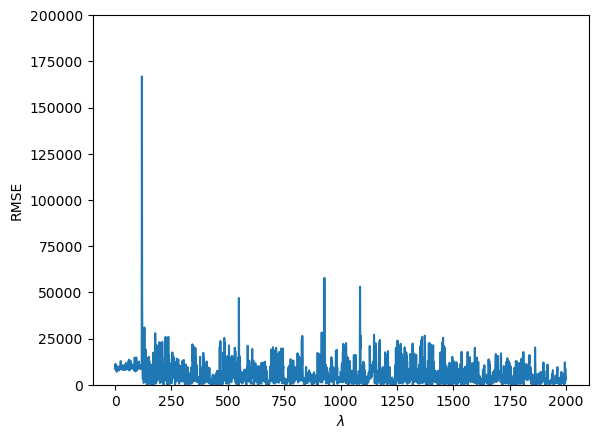

In [30]:
m=2000
plt.plot(range(m),np.sqrt( (Y_training[:m] - X_training[:m, :].dot(trained_model)) **2) * avg_size)
plt.xlabel('$\lambda$')             # ^-- questo sopra è l'errore associato ad ogni punto
plt.ylabel('RMSE')
plt.ylim([0, 200000])
plt.show()

---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

In [22]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    ## TODO: Run the LS algorithm with regularization
    # Create A and b as in unregularized LS
    A = np.transpose(X_matrix).dot(X_matrix)
    b = np.transpose(X_matrix).dot(labels)
    # Add the regularization part in the inverse
    coeff = np.linalg.inv(A + lambda_par * np.eye(np.shape(A)[0])).dot(b)      # <-- questa volta invertiamo A + il parametro lambda per la matrice I
    return coeff

def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    ## TODO: Perform K-fold cross-validation             # stesso K_fold dello scorso lab, più o meno
    perm = np.arange(0, np.shape(X_training)[0], 1)
    rnd.shuffle(perm)                                    
    X_shuffled = np.asarray(X_training[perm, :])       
    Y_shuffled = np.asarray(Y_training[perm])
    best = -1
    best_perf = 1e20
    results = []
    models = []
    max_idx = np.shape(Y_training)[0]
    # Divide training set in K folds
    fold_points = int(np.floor(max_idx / K))
    for lambda_idx in range(len(lambda_vec)):
        lambda_perf = 0
        for test in range(K):
            x_train_fold = np.concatenate([X_shuffled[: fold_points * test, :], X_shuffled[fold_points * (test + 1) + 1 :, :]])
            y_train_fold = np.concatenate([Y_shuffled[: fold_points * test], Y_shuffled[fold_points * (test + 1) + 1 :]])
            x_validate_fold = X_shuffled[fold_points * test : fold_points * (test + 1) + 1, :]
            y_validate_fold = Y_shuffled[fold_points * test : fold_points * (test + 1) + 1]
            k_model = regularized_least_squares(x_train_fold, y_train_fold, lambda_par[lambda_idx])
            lambda_perf += evaluate_model(x_validate_fold, y_validate_fold, k_model)
        lambda_perf /= K
        results.append(lambda_perf)
        models.append(regularized_least_squares(X_shuffled, Y_shuffled, lambda_par[lambda_idx]))
        if (best_perf > lambda_perf):
            best = regularized_least_squares(X_shuffled, Y_shuffled, lambda_par[lambda_idx])
            best_perf = lambda_perf
    return best, best_perf, models, results

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\feder\AppData\Local\Temp\ipykernel_16924\451200057.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


[0.36956527 0.20449419 0.42490712] [0.02142914834620689, 0.021429123597762514, 0.02142910804790683, 0.021429101528371148, 0.021429103874157578, 0.021429114923468544, 0.021429134517637706, 0.021429162501063023, 0.02142919872114095, 0.021429243028202472, 0.02142929527545063, 0.02142935531889944, 0.02142942301731455, 0.021429498232154863, 0.021429580827515966, 0.02142967067007457, 0.02142976762903457, 0.021429871576074115, 0.021429982385293853, 0.021430099933166923, 0.02143022409848931, 0.02143035476233208, 0.021430491807994192, 0.021430635120956786, 0.021430784588838188, 0.021430940101350302, 0.02143110155025571, 0.02143126882932584, 0.021431441834300128, 0.021431620462846152, 0.021431804614520475, 0.021431994190730587, 0.021432189094697594, 0.021432389231419838, 0.021432594507637088, 0.021432804831795875, 0.02143302011401541, 0.02143324026605418, 0.02143346520127748, 0.02143369483462562, 0.021433929082582587, 0.021434167863145892, 0.021434411095796423, 0.02143465870146969, 0.02143491060

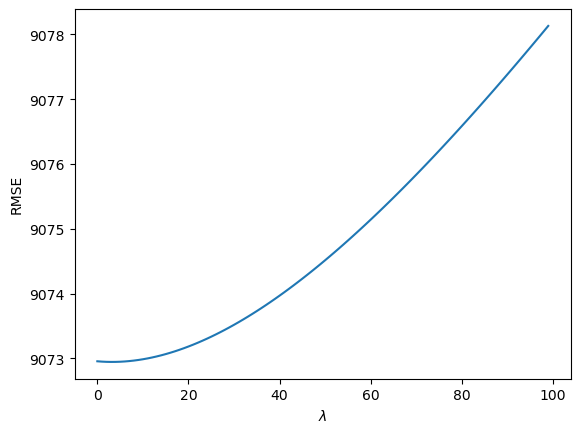

In [26]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = range(100)

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


In [33]:
# la migliore lambda è quella attorno a 10

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\feder\AppData\Local\Temp\ipykernel_16924\1799133235.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


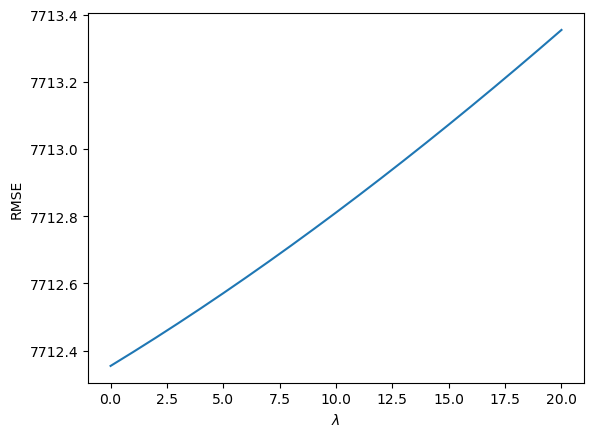

In [24]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


### EXTRA

Can you figure out the best amount of memory to use?
